In [1]:
import os
import faiss
import pinecone
import PIL
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch

from PIL import Image
from tqdm import tqdm
from datasets import Dataset, Image
from torch.utils.data import DataLoader
from typing import List, Union, Tuple
from transformers import CLIPProcessor, CLIPModel

2025-03-25 19:37:17.755680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 19:37:17.884355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-25 19:37:17.884406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-25 19:37:17.902621: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 19:37:17.942352: I tensorflow/core/platform/cpu_feature_guar

## **Creating Image Embedding Using OpenAI Clip**

In [2]:
device = "cpu"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [3]:
image_path = os.listdir("/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/Flicker_8k/Images/")
image_path = ['/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/Flicker_8k/Images/' + path for path in image_path if '.jpg' in path]
image_path.sort()

In [4]:
captions_df = pd.read_csv('/home/abhinav/Documents/Work/2 Hobby_projects/Datasets/Flicker_8k/captions.csv')

In [5]:
## Uncomment if you need to create a file of all image encodings

# def encode_images(images: Union[List[str], List[PIL.Image.Image]], batch_size: int):
#     def transform_fn(el):
#         if isinstance(el['image'], PIL.Image.Image):
#             imgs = el['image']
#         else:
#             imgs = [Image().decode_example(_) for _ in el['image']]
#         return preprocess(images=imgs, return_tensors='pt')
        
#     dataset = Dataset.from_dict({'image': images})
#     dataset = dataset.cast_column('image',Image(decode=False)) if isinstance(images[0], str) else dataset       
#     dataset.set_format('torch')
#     dataset.set_transform(transform_fn)
#     dataloader = DataLoader(dataset, batch_size=batch_size)
#     image_embeddings = []
#     pbar = tqdm(total=len(images) // batch_size, position=0)
#     with torch.no_grad():
#         for batch in dataloader:
#             batch = {k:v.to(device) for k,v in batch.items()}
#             image_embeddings.extend(model.get_image_features(**batch).detach().cpu().numpy())
#             pbar.update(1)
#         pbar.close()
#     return np.stack(image_embeddings)

# vector_embedding = np.array(encode_images(image_path,32))

In [6]:
def encode_text( text: List[str], batch_size: int):
    device =  "cpu"
    dataset = Dataset.from_dict({'text': text})
    dataset = dataset.map(lambda el: preprocess(text=el['text'], return_tensors="pt",
                                                        max_length=77, padding="max_length", truncation=True),
                            batched=True,
                            remove_columns=['text'])
    dataset.set_format('torch')
    dataloader = DataLoader(dataset, batch_size=batch_size)
    text_embeddings = []
    pbar = tqdm(total=len(text) // batch_size, position=0)
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            text_embeddings.extend(model.get_text_features(**batch).detach().cpu().numpy())
            pbar.update(1)
        pbar.close()
    return np.stack(text_embeddings)

## **Saving Image Embeddings as JSON**

In [7]:
# with open('/home/abhinav/Desktop/AIProjects/Internship/IIT Patna/CLIP/flicker8k_image_embeddings.pkl','wb') as f:
#     pickle.dump(vector_embedding, f)

In [8]:
import pickle
with open('/home/abhinav/Desktop/AIProjects/Internship/IIT Patna/CLIP/CLIP_IMG_SEARCH/flicker8k_image_embeddings.pkl','rb') as fp:
    vector_embedding = pickle.load(fp)

## **Building Index Using FAISS**

In [9]:
index = faiss.IndexFlatIP(vector_embedding.shape[1])
index.add(vector_embedding)

## **Text to Image Search**

In [34]:
search_text = "Swimming"
with torch.no_grad():
    text_search_embedding = encode_text([search_text], batch_size=32)
text_search_embedding = text_search_embedding/np.linalg.norm(text_search_embedding, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 28.03it/s]


In [35]:
distances, indices = index.search(text_search_embedding.reshape(1, -1), 5)
distances = distances[0]
indices = indices[0]

indices_distances = list(zip(indices, distances))
indices_distances.sort(key=lambda x: x[1])  # Sort based on the distances

print(indices_distances)

[(4099, 3.1796339), (1170, 3.202757), (2872, 3.211719), (6874, 3.2483754), (7833, 3.2557948)]


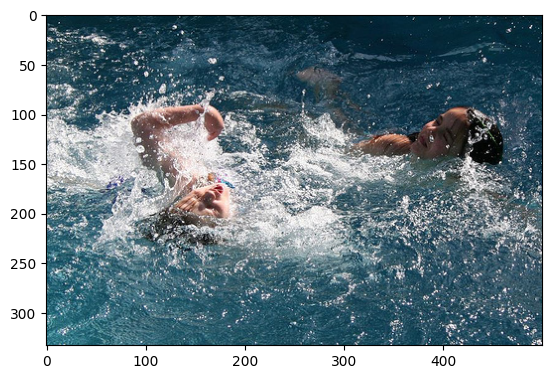

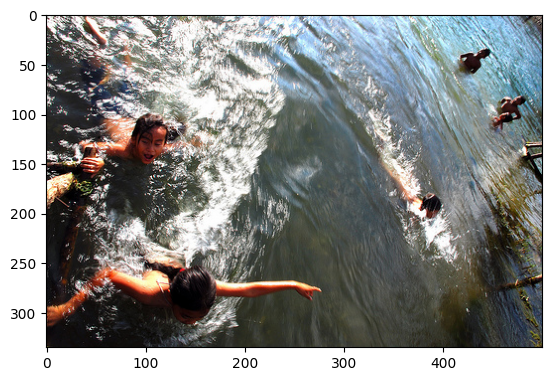

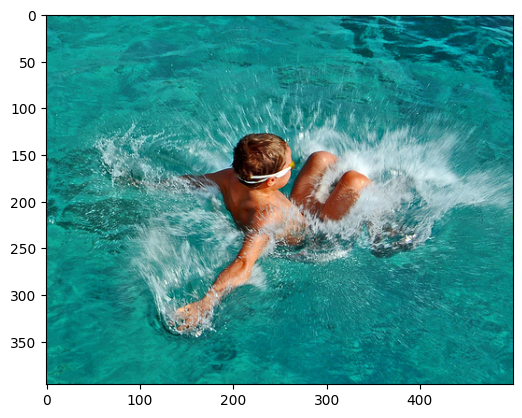

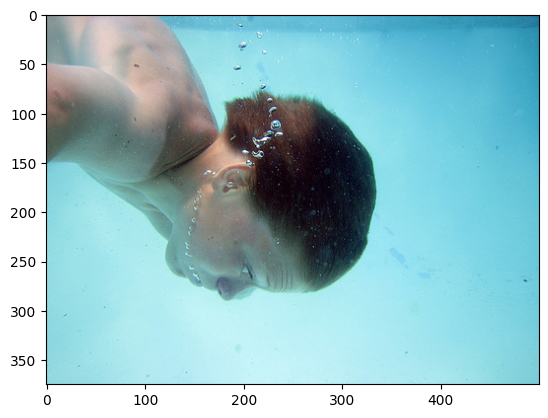

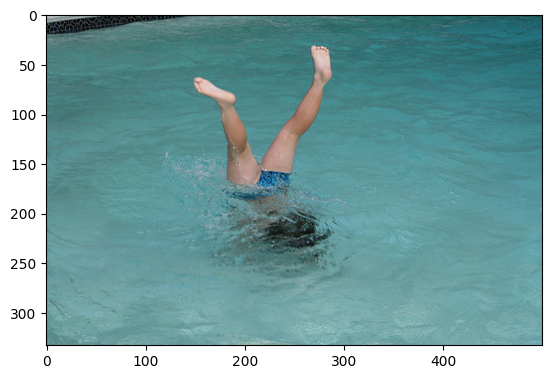

In [36]:
from PIL import Image
for idx, distance in indices_distances:
    path = image_path[idx]
    im = Image.open(path)
    plt.imshow(im)
    plt.show()